### Use `RGBD` camera

In [1]:
import mujoco,cv2,pyvista
import numpy as np
import matplotlib.pyplot as plt
# from pyntcloud import PyntCloud
import sys
sys.path.append('../../')
from utils.mujoco_parser import MuJoCoParserClass
from utils.util import sample_xyzs,rpy2r,r2rpy,compute_view_params,get_interp_const_vel_traj
np.set_printoptions(precision=2,suppress=True,linewidth=100)
plt.rc('xtick',labelsize=6); plt.rc('ytick',labelsize=6)
%config InlineBackend.figure_format = 'retina'
%matplotlib inline
print ("MuJoCo version:[%s]"%(mujoco.__version__))

MuJoCo version:[2.3.4]


### Parse `UR5e` with `RG2` gripper

In [2]:
xml_path = '../../asset/ur5e/scene_ur5e_rg2_obj.xml'
env = MuJoCoParserClass(name='UR5e with RG2 gripper',rel_xml_path=xml_path,VERBOSE=True)
obj_names = [body_name for body_name in env.body_names
             if body_name is not None and (body_name.startswith("obj_"))]
n_obj = len(obj_names)
# Place objects
xyzs = sample_xyzs(n_sample=n_obj,
                   x_range=[-5,-7],y_range=[-0.38,0.38],z_range=[0.81,0.81],min_dist=0.2)
colors = np.array([plt.cm.gist_rainbow(x) for x in np.linspace(0,1,n_obj)])
for obj_idx,obj_name in enumerate(obj_names):
    jntadr = env.model.body(obj_name).jntadr[0]
    env.model.joint(jntadr).qpos0[:3] = xyzs[obj_idx,:]
    geomadr = env.model.body(obj_name).geomadr[0]
    # env.model.geom(geomadr).rgba = colors[obj_idx] # color

# Move tables and robot base
env.model.body('base_table').pos = np.array([0,0,0.])
env.model.body('front_object_table').pos = np.array([0.85,0,0])
env.model.body('side_object_table').pos = np.array([0,-2.85,0])
env.model.body('base').pos = np.array([0,0,0.8+0.15])
print ("Ready.")

dt:[0.0020] HZ:[500]
n_dof (=nv):[60]
n_geom:[52]
geom_names:['floor', None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None, None]
n_body:[29]
body_names:['world', 'base', 'shoulder_link', 'upper_arm_link', 'forearm_link', 'wrist_1_link', 'wrist_2_link', 'wrist_3_link', 'tcp_link', 'camera_mount', 'rg2_gripper_base_link', 'camera_center', 'rg2_gripper_finger1_finger_link', 'rg2_gripper_finger1_inner_knuckle_link', 'rg2_gripper_finger1_finger_tip_link', 'rg2_gripper_finger2_finger_link', 'rg2_gripper_finger2_inner_knuckle_link', 'rg2_gripper_finger2_finger_tip_link', 'front_object_table', 'side_object_table', 'base_table', 'obj_cylinder_01', 'obj_cylinder_02', 'obj_cylinder_03', 'obj_cylinder_04', 'obj_cylinder_05', 'obj_cylinder_06', 'obj_cylin

### Render

In [3]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Base pose
body_name = 'tcp_link'
p_base = env.get_p_body(body_name='base')

# Straight pose
DO_RENDER_IK = True
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,0,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_00 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=np.radians([0,-90,0,0,0,0]),rev_joint_idxs=rev_joint_idxs,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-2)

# 30 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,30,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_30 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_00,rev_joint_idxs=rev_joint_idxs,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-4)

# 60 deg down pose
p_trgt = p_base + np.array([0.4,0,0.6])
R_trgt = rpy2r(np.radians([0,60,0]))@rpy2r(np.radians([-180,0,90]))
rev_joint_idxs = [0,1,2,3,4,5]
q_prepose_60 = env.solve_ik(
    body_name=body_name,p_trgt=p_trgt,R_trgt=R_trgt,IK_P=True,IK_R=True,
    q_init=q_prepose_30,rev_joint_idxs=rev_joint_idxs,
    RESET=False,DO_RENDER=DO_RENDER_IK,render_every=10,th=1*np.pi/180.0,err_th=1e-4)

env.close_viewer()
print ("IK done.")

# Get joint trajectory
times,q_traj = get_interp_const_vel_traj(
    np.vstack((q_prepose_60,q_prepose_30,q_prepose_30,q_prepose_60)),
    vel=np.radians(30),HZ=env.HZ)
print ("q_traj's L:[%d] time_max:[%.2f]sec"%(times.shape[0],times[-1]))


IK done.
q_traj's L:[1259] time_max:[2.52]sec


In [4]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

pcd_tick = 0

# Reset
env.reset()
env.forward(q=q_traj[0,:],joint_idxs=[0,1,2,3,4,5])
tick,max_sec = 0,100
while env.get_sim_time() <= max_sec:
    # Step
    q = np.append(q_traj[tick,:],1.0) # open gripper
    env.step(ctrl=q,ctrl_idxs=[0,1,2,3,4,5,6])
    tick = min(tick + 1,q_traj.shape[0]-1)
    if not env.is_viewer_alive(): break
        
    # Render
    if env.loop_every(HZ=20):
        # Compute some poses
        p_tcp,R_tcp = env.get_pR_body(body_name='tcp_link')
        p_cam,R_cam = env.get_pR_body(body_name='camera_center')
        p_base,R_base = env.get_pR_body(body_name='base')
        # Get PCD from a specific view
        p_ego  = p_cam
        p_trgt = p_cam + R_cam[:,2]
        rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
            p_ego=p_ego,p_trgt=p_trgt,rsz_rate=20,fovy=45,BACKUP_AND_RESTORE_VIEW=True)

        # Save PCD
        pcd_tick += 1
        # for p in pcd: env.plot_sphere(p=p,r=0.005,rgba=[0.95,0.05,0.05,1])
        env.render(render_every=1)
        
# Close viewer
env.close_viewer()
print ("Done. Tick:[%d] Time:[%.2f]sec"%(env.tick,env.get_sim_time()))

Pressed ESC
Quitting.
Done. Tick:[627] Time:[1.25]sec


In [5]:
import numpy as np

def point_to_voxel_index(point, voxel_size, offset):
    return ((point - offset) / voxel_size).astype(int)

def pointcloud_to_voxelgrid(point_cloud, voxel_size):
    offset = point_cloud.min(axis=0)
    
    # Compute the maximum voxel index and add one to handle edge case
    max_index = point_to_voxel_index(point_cloud.max(axis=0), voxel_size, offset) + 1

    voxel_grid = np.zeros((max_index), dtype=np.uint8)
    
    for point in point_cloud:
        index = point_to_voxel_index(point, voxel_size, offset)
        voxel_grid[tuple(index)] = 1
        
    return voxel_grid


In [6]:
import numpy as np
import pyvista as pv

def point_to_voxel_index(point, voxel_size, offset):
    return ((point - offset) / voxel_size).astype(int)

def pointcloud_to_voxelgrid(point_cloud, voxel_size):
    offset = point_cloud.min(axis=0)
    
    # Compute the maximum voxel index and add one to handle edge case
    max_index = point_to_voxel_index(point_cloud.max(axis=0), voxel_size, offset) + 1

    voxel_grid = np.zeros((max_index), dtype=np.uint8)
    
    for point in point_cloud:
        index = point_to_voxel_index(point, voxel_size, offset)
        voxel_grid[tuple(index)] = 1
        
    return voxel_grid\
    
# Assume `point_cloud` is your point cloud data
voxel_size = 0.1  # Modify as needed
voxel_grid = pointcloud_to_voxelgrid(pcd, voxel_size)

In [7]:
def pointcloud_to_voxelgrid(point_cloud, colors, voxel_size):
    offset = point_cloud.min(axis=0)

    max_index = point_to_voxel_index(point_cloud.max(axis=0), voxel_size, offset) + 1

    voxel_grid = np.zeros((*max_index, 3), dtype=np.uint8)

    for (point, color) in zip(point_cloud, colors):
        index = point_to_voxel_index(point, voxel_size, offset)
        voxel_grid[tuple(index)] = color

    return voxel_grid

def visualize_voxel_grid_pyvista(voxel_grid):
    x, y, z = np.where(np.any(voxel_grid > 0, axis=-1))

    colors = voxel_grid[x, y, z] / 255.0

    cloud = pv.PolyData(np.vstack((x,y,z)).T)

    cloud['colors'] = colors

    pv.plot(cloud, point_size=voxel_size, render_points_as_spheres=True, point_color='colors')


In [8]:
x, y, z = np.where(voxel_grid == 1)
grid = pv.StructuredGrid(x, y, z)


/home/rilab/.local/lib/python3.8/site-packages/pyvista/utilities/helpers.py:507: UserWarning: Points is not a float type. This can cause issues when transforming or applying filters. Casting to ``np.float32``. Disable this by passing ``force_float=False``.
  warnings.warn(


In [9]:
grid

StructuredGrid,Information
N Cells,1602
N Points,1603
X Bounds,"0.000e+00, 1.200e+02"
Y Bounds,"0.000e+00, 1.440e+02"
Z Bounds,"0.000e+00, 7.000e+00"
Dimensions,"1603, 1, 1"
N Arrays,0


In [10]:
# Get the coordinates of non-empty voxels
x, y, z = np.where(voxel_grid == 1)

# Create a grid of points (coordinates of non-empty voxels)
cloud = pv.PolyData(np.vstack((x,y,z)).T)

# Visualize the point cloud
pv.plot(cloud)

Widget(value="<iframe src='http://localhost:43063/index.html?ui=P_0x7f0c9cc886d0_0&reconnect=auto' style='widt…

In [11]:
pv.plot(grid)

Widget(value="<iframe src='http://localhost:43063/index.html?ui=P_0x7f0c98224790_1&reconnect=auto' style='widt…

In [12]:
def pointcloud_to_voxelgrid(point_cloud, colors, voxel_size):
    offset = point_cloud.min(axis=0)

    max_index = point_to_voxel_index(point_cloud.max(axis=0), voxel_size, offset) + 1

    voxel_grid = np.zeros((*max_index, 3), dtype=np.uint8)

    for (point, color) in zip(point_cloud, colors):
        index = point_to_voxel_index(point, voxel_size, offset)
        voxel_grid[tuple(index)] = color

    return voxel_grid


In [13]:
import numpy as np

def pcd_to_voxel(pcd_data, voxel_size):
    # Get the minimum and maximum bounds of the point cloud
    min_bounds = np.min(pcd_data, axis=0)
    max_bounds = np.max(pcd_data, axis=0)

    # Calculate the dimensions of the voxel grid based on the voxel size
    voxel_shape = np.ceil((max_bounds - min_bounds) / voxel_size).astype(int)

    # Create an empty voxel grid
    voxel_grid = np.zeros(voxel_shape, dtype=np.uint8)

    # Calculate the voxel indices for each point in the point cloud
    voxel_indices = np.floor((pcd_data - min_bounds) / voxel_size).astype(int)

    # Set the occupied voxels to 1
    voxel_grid[voxel_indices[:, 0], voxel_indices[:, 1], voxel_indices[:, 2]] = 1

    return voxel_grid

if __name__ == "__main__":
    # Replace 'pcd_data' with your actual NumPy array representing the point cloud
    pcd_data = pcd

    # Set the desired voxel size (e.g., 0.1, 0.05, etc.)
    voxel_size = 0.1

    voxel_representation = pcd_to_voxel(pcd_data, voxel_size)
    print(voxel_representation)


[[[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 ...

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]]

 [[0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]

 [[1 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [1 0 0 ... 0 0 0]
  ...
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]
  [0 0 0 ... 0 0 0]]]


In [14]:
voxel_representation.shape

(121, 145, 8)

In [15]:
grid

StructuredGrid,Information
N Cells,1602
N Points,1603
X Bounds,"0.000e+00, 1.200e+02"
Y Bounds,"0.000e+00, 1.440e+02"
Z Bounds,"0.000e+00, 7.000e+00"
Dimensions,"1603, 1, 1"
N Arrays,0


In [16]:
from collections import defaultdict

def point2voxel(pcd, voxel_size: float):
    voxel_dict = defaultdict(list)
    for i in range(pcd.shape[0]):
        xyz = pcd[i, :]
        xyz_index = tuple(xyz // voxel_size)
        voxel_dict[xyz_index].append(xyz)
    voxel = np.vstack([np.mean(v, axis=0) for v in voxel_dict.values()])
    return voxel

In [17]:
original_points = pcd
print(f"{original_points.shape=}")
voxel_size = .5
voxel_sampling_points = point2voxel(original_points, voxel_size)

original_points.shape=(2400, 3)


In [18]:
def plot_sampled_points(original_points, sampled_points, method_name):
    fig = plt.figure()
    ax = fig.add_subplot(projection='3d')
    ax.scatter(original_points[:, 0], original_points[:, 1],
               original_points[:, 2], marker=".", label="Original points")
    ax.scatter(sampled_points[:, 0], sampled_points[:, 1],
               sampled_points[:, 2], marker="o",
               label="Filtered points")
    plt.legend()
    plt.title(method_name)
    plt.axis("equal")

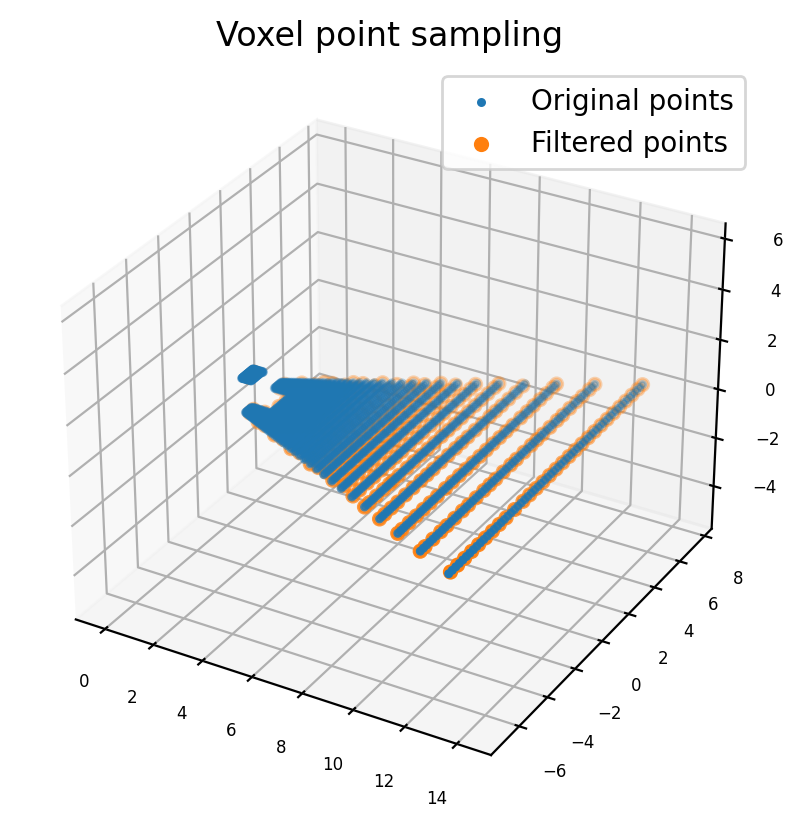

In [19]:
plot_sampled_points(original_points, voxel_sampling_points,
                    "Voxel point sampling")

In [49]:
# passthrough filter about z axis
def passthrough_filter(pcd, axis, interval):
    mask = (pcd[:, axis] > interval[0]) & (pcd[:, axis] < interval[1])
    return pcd[mask]
pcd_masked = passthrough_filter(pcd, axis=2, interval=[0.5, 1.0])
original_points = pcd_masked
print(f"{original_points.shape=}")
voxel_size = 0.05
voxel_sampling_points = point2voxel(original_points, voxel_size)

original_points.shape=(378, 3)


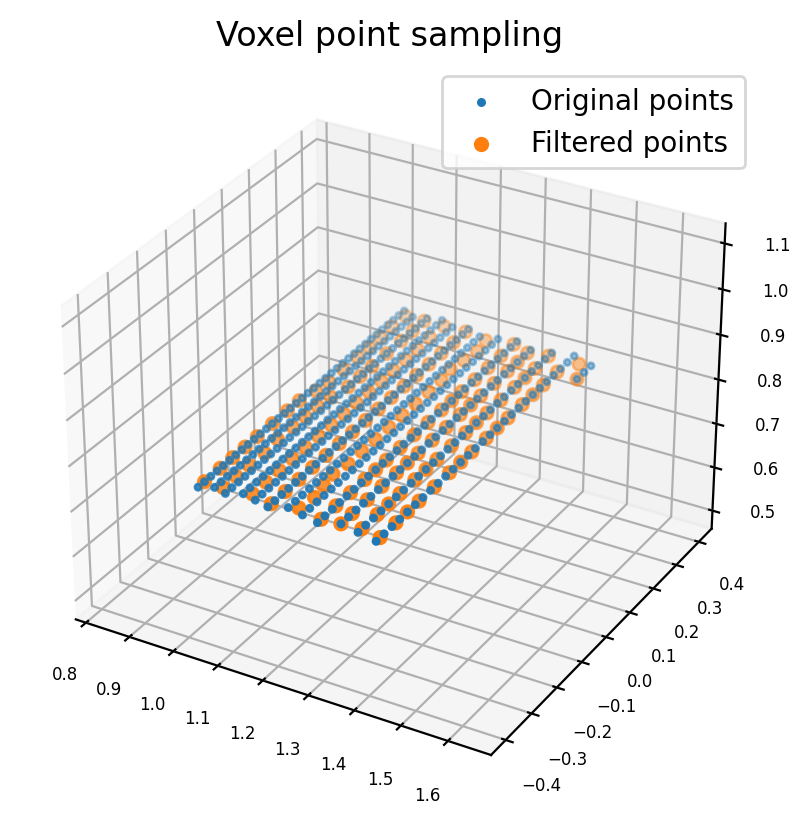

In [50]:
plot_sampled_points(pcd_masked, voxel_sampling_points,
                    "Voxel point sampling")

### Check current egocentric view

rgb_img:(800, 1200, 3), depth_img:(800, 1200), pcd:(9600, 3), xyz_img:(80, 120, 3)


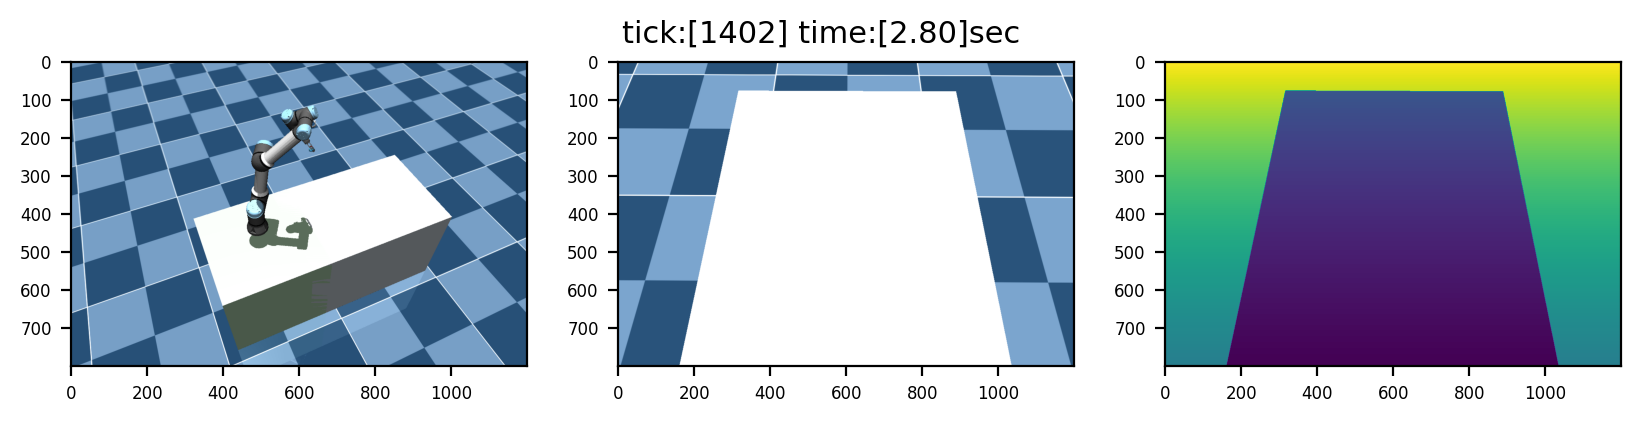

In [48]:
# Init viewer
env.init_viewer(viewer_title='UR5e with RG2 gripper',viewer_width=1200,viewer_height=800,
                viewer_hide_menus=True)
env.update_viewer(azimuth=66.08,distance=3.0,elevation=-50,lookat=[0.4,0.18,0.71],
                  VIS_TRANSPARENT=False,VIS_CONTACTPOINT=False,
                  contactwidth=0.05,contactheight=0.05,contactrgba=np.array([1,0,0,1]),
                  VIS_JOINT=True,jointlength=0.25,jointwidth=0.05,jointrgba=[0.2,0.6,0.8,0.6])

# Get egocentric view
rgb_img,depth_img,pcd,xyz_img = env.get_egocentric_rgb_depth_pcd(
    p_ego=p_ego,p_trgt=p_trgt,rsz_rate=10,fovy=45,BACKUP_AND_RESTORE_VIEW=True)
# Print
print ("rgb_img:%s, depth_img:%s, pcd:%s, xyz_img:%s"%
       (rgb_img.shape,depth_img.shape,pcd.shape,xyz_img.shape))
# Plot
fig,axs = plt.subplots(1,3,figsize=(10,2))
scene_img = env.grab_image()
axs[0].imshow(scene_img); axs[1].imshow(rgb_img); axs[2].imshow(depth_img)
fig.suptitle('tick:[%d] time:[%.2f]sec'%(env.tick,env.get_sim_time()),fontsize=11)
plt.subplots_adjust(wspace=0.2); plt.show()
# Close viewer
env.close_viewer()

### Plot point cloud using `PyVista` with `Panel`

In [49]:
import pyvista as pv
point_cloud = pv.PolyData(pcd)
point_cloud['height'] = point_cloud.points[:,2]
point_cloud.plot(window_size=[500,500],jupyter_backend='panel',
                 cmap='jet',point_size=4,background='w',border=True)

BokehModel(combine_events=True, render_bundle={'docs_json': {'0cb3d8eb-31d7-49e0-9202-c64844fe73f2': {'version…

In [50]:
pcd.shape

(9600, 3)